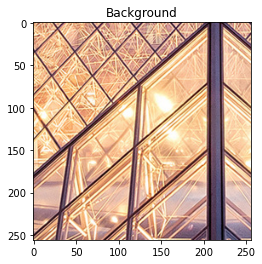

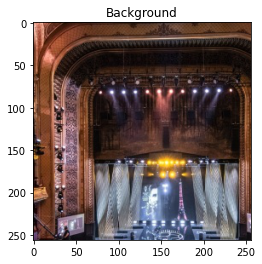

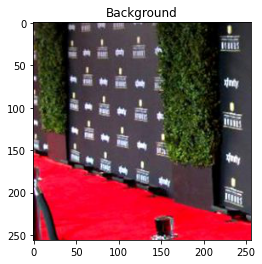

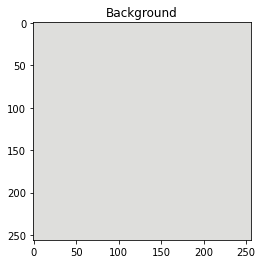

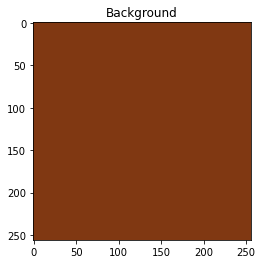

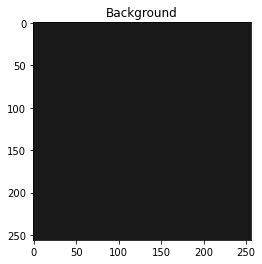

In [51]:
import torch as th
import glob, os
from PIL import Image
import blobfile as bf
import matplotlib.pyplot as plt
import numpy as np


def load_image(path):
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    return pil_image

def face_segment(face_segment_anno, segment_part):
    face_segment_anno = np.array(face_segment_anno)
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))
    
    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out
        

in_images = glob.glob('../debugging_img/original_images/images/valid/*')
mask_path = '../debugging_img/original_images/face_segment/valid/anno/'


def replace_bg(bg, name, size=256):
    
    out_images = f'../debugging_img/replace_bg/{name}_images/images/valid/'
    os.makedirs(out_images, exist_ok=True)
    if type(bg) == str:
        bg = np.array(load_image(bg))
        np.random.seed(23)
        tlx = np.random.randint(low=0, high=bg.shape[0]-size)
        tly = np.random.randint(low=0, high=bg.shape[1]-size)
        bg = bg[tlx:tlx+size, tly:tly+size, :]
    elif type(bg) == list:
        sbg = np.ones((256, 256, 3))
        sbg[..., [0]] = sbg[..., [0]] * bg[0]
        sbg[..., [1]] = sbg[..., [1]] * bg[1]
        sbg[..., [2]] = sbg[..., [2]] * bg[2]
        bg = sbg.astype(np.uint8)
        
    plt.title("Background")
    plt.imshow(bg)
    plt.show()
    
    for img_fn in in_images:
        anno_fn = f"{mask_path}/anno_{img_fn.split('/')[-1].split('.')[0]}.png"
        
        img = load_image(img_fn)
        anno = load_image(anno_fn)
        mask = face_segment(anno, 'faceseg_head')
        
        replace_bg = (mask * img) + (~mask * bg)
        
        # plt.title("Original & Anno & Maks & Replace")
        # plt.imshow(np.concatenate((np.array(img), np.array(anno), np.array(mask)*255, np.array(replace_bg)), axis=1))
        # plt.show()
        replace_bg = Image.fromarray(replace_bg)
        replace_bg.save(fp=f"{out_images}/bg{img_fn.split('/')[-1].split('.')[0]}.jpg")

gray = [222, 222, 220]
orange = [128, 56, 18]
black = [25, 25, 25]
replace_bg(name='louve', bg='./louve.jpg')
replace_bg(name='bd', bg='./bd.jpg')
replace_bg(name='rc', bg='./rc.jpg')
replace_bg(name='gray', bg=gray)
replace_bg(name='orange', bg=orange)
replace_bg(name='black', bg=black)